In [ ]:
import io
import time
import torch
import torchaudio
import random

from encodec.model import EncodecModel

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import numpy as np
import pylab as plt

In [ ]:
from IPython.display import Audio, HTML, display

In [ ]:
datadir = Path('/mnt/')

# Modeling

In [ ]:
!ls -lh speech-1401/histories3_09_herodotus_64kb.encodec
!ls -lh /mnt/whisper-distil/whisper-tiny-decoder-1401/histories3_09_herodotus_64kb.semtok

ls: cannot access 'speech-1401/histories3_09_herodotus_64kb.encodec': No such file or directory
-rw-r--r-- 1 user user 327K Feb 25 17:32 /mnt/whisper-distil/whisper-tiny-decoder-1401/histories3_09_herodotus_64kb.semtok


In [ ]:
# we use speaker 1401 from small and medium LibreLite datasets
train_S = []
train_A = []
for name in progress_bar(list((datadir/'semantic-small/1401/').rglob('*.stoks'))):
    S = torch.load(name)
    train_S.append(S)
    train_A.append(torch.load(datadir/'acoustic-1401'/name.with_suffix('.encodec').name)[0])

for name in progress_bar(list((datadir/'semantic-medium/1401/').rglob('*.stoks'))):
    S = torch.load(name)
    train_S.append(S)
    train_A.append(torch.load(datadir/'acoustic-medium/1401'/name.with_suffix('.encodec').name)[0])

    
len(train_S), sum([len(x) for x in train_S])

(720, 19674)

In [ ]:
all_samples = [(i,Si,Si*2250) for i,S in enumerate(train_S) for Si in range(S.shape[0]-1)]
len(all_samples), len(all_samples)*30/3600

(18954, 157.95)

In [ ]:
all_samples[:33]

[(0, 0, 0),
 (0, 1, 2250),
 (0, 2, 4500),
 (0, 3, 6750),
 (0, 4, 9000),
 (0, 5, 11250),
 (0, 6, 13500),
 (0, 7, 15750),
 (0, 8, 18000),
 (0, 9, 20250),
 (0, 10, 22500),
 (0, 11, 24750),
 (0, 12, 27000),
 (0, 13, 29250),
 (0, 14, 31500),
 (0, 15, 33750),
 (0, 16, 36000),
 (0, 17, 38250),
 (0, 18, 40500),
 (0, 19, 42750),
 (0, 20, 45000),
 (0, 21, 47250),
 (1, 0, 0),
 (1, 1, 2250),
 (1, 2, 4500),
 (1, 3, 6750),
 (1, 4, 9000),
 (1, 5, 11250),
 (1, 6, 13500),
 (1, 7, 15750),
 (1, 8, 18000),
 (1, 9, 20250),
 (1, 10, 22500)]

In [ ]:
train_S[0].shape

torch.Size([23, 1500, 3])

In [ ]:
train_A[0].shape

torch.Size([2, 50026])

### Input transformation from 3 tokens per time-step to a linear embeddings vector

In [ ]:
i,iS,iA = all_samples[5]
i,iS,iA

(0, 5, 11250)

In [ ]:
xs = train_S[i][iS].cuda().to(torch.long)

In [ ]:
# embed the 3 RQ tokens separately and interleave them
Sembs = [enc(xs[:,i]) for i,enc in enumerate(model.encoder.embeddings)]
xin = torch.cat(Sembs, dim=-1).reshape(1, -1, Sembs[0].shape[-1])
xin.shape

torch.Size([1, 4500, 384])

Make sure we arranged the token embdeddings correctly:

In [ ]:
xin[0,:3]

tensor([[ 0.1216,  0.1005, -0.1763,  ...,  0.1723, -1.9617,  1.9209],
        [ 1.3165,  1.3317, -0.4884,  ...,  0.5334,  0.1524, -1.2212],
        [-0.6608, -0.1641,  0.3342,  ...,  0.3704, -0.0337, -1.4403]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
xs[:2]

tensor([[1196,  385, 1192],
        [ 281, 1919, 1810]], device='cuda:0')

In [ ]:
torch.cat([model.encoders[0](torch.tensor([1196]).cuda()),
 model.encoders[1](torch.tensor([385]).cuda()),
 model.encoders[2](torch.tensor([1192]).cuda())])

tensor([[ 0.1216,  0.1005, -0.1763,  ...,  0.1723, -1.9617,  1.9209],
        [ 1.3165,  1.3317, -0.4884,  ...,  0.5334,  0.1524, -1.2212],
        [-0.6608, -0.1641,  0.3342,  ...,  0.3704, -0.0337, -1.4403]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [ ]:
# alternatively embed them separately and add them into a single value (mirros RQ process, less tokens -> faster)
Sembs = sum([enc(xs[:,i]) for i,enc in enumerate(model.encoder.embeddings)]).unsqueeze(0)
Sembs.shape

torch.Size([1, 1500, 384])

### Output transformation from 3\*1500 logits into 2\*2250 acoustic tokens

In [ ]:
# output acoustic tokens
ys = train_A[i][:,iA:iA+2250]
ys.shape, ys

(torch.Size([2, 2250]),
 tensor([[475, 796, 837,  ..., 944, 413, 320],
         [516, 690, 367,  ..., 872, 512, 185]], device='cuda:0'))

In [ ]:
# linearize (interleaving)
l_ys = ys.T.reshape(-1); l_ys

tensor([475, 516, 796,  ..., 512, 320, 185], device='cuda:0')

In [ ]:
# back into EnCodec shape
l_ys.reshape(-1,2).T

tensor([[475, 796, 837,  ..., 944, 413, 320],
        [516, 690, 367,  ..., 872, 512, 185]], device='cuda:0')

In [ ]:
# same for model outputs
p = model(xs).argmax(-1); p

tensor([[463, 463, 463,  ..., 544, 106, 544]], device='cuda:0')

In [ ]:
p.reshape(-1,2).T

tensor([[463, 463, 463,  ..., 424, 792, 106],
        [463, 463, 690,  ..., 432, 544, 544]], device='cuda:0')

In [ ]:
ys.shape

torch.Size([2, 2250])

In [ ]:
# separate embedding matrices for each token in the pair
[emb(t) for t,emb in zip(ys, model.decoder.embeddings)]

[tensor([[-0.0221, -0.9929, -0.0916,  ...,  0.2521, -0.4327, -0.0791],
         [ 0.7580,  0.3619,  0.2989,  ..., -1.6362, -1.0662,  0.0167],
         [ 0.7007,  0.0425, -0.3149,  ..., -0.2235, -0.9771, -0.0353],
         ...,
         [-0.7925,  0.1081,  0.3967,  ...,  0.3948, -1.1281, -2.0738],
         [ 0.1734, -0.8677, -0.2587,  ..., -1.2214, -0.0953,  0.0960],
         [-0.4839,  1.4725, -0.3920,  ...,  0.9135, -0.9904, -0.4578]],
        device='cuda:0', grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.5147,  0.3781,  1.4651,  ..., -1.7021,  1.6027, -0.4638],
         [ 0.9090, -1.0502, -0.5515,  ...,  0.0161, -1.3197,  0.0908],
         [ 1.1644,  0.6203, -0.3811,  ...,  0.3710,  0.1463, -2.4382],
         ...,
         [-0.7055, -2.0416, -0.1226,  ...,  0.8340,  0.0536, -1.0173],
         [-0.1261,  0.5721,  0.7107,  ..., -2.1779,  1.1358,  0.4281],
         [ 0.8426,  1.7698,  0.7107,  ..., -0.3900, -0.4509, -2.4284]],
        device='cuda:0', grad_fn=<EmbeddingBackward0>)]

In [ ]:
# interleaving the separately embedded tokens
Aemb = torch.stack([emb(t) for t,emb in zip(ys, model.decoder.embeddings)], dim=1)
Aemb = Aemb.reshape(-1, Aemb.shape[-1]).cuda().unsqueeze(0)
Aemb.shape

torch.Size([1, 4500, 384])

In [ ]:
# instead of learning a new linear layer to generate logits (like GPT-2 does)
# we can use correlations between the activations and correspondng embedding vectors as logits (like Whisper)
torch.stack([(x @ emb.weight.to(x.dtype).T) for x, emb in zip(Aemb.reshape(-1,2,Aemb.shape[-1]).transpose(0,1), model.decoder.embeddings)], dim=0).shape
# we can do it because we have interleaved the tokens (instead of adding their embeddings)

torch.Size([2, 2250, 1025])

In [ ]:
# training code
import torch.optim as optim
import torch.nn.functional as F
import random
import IPython

def train(vqmodel, xs, ys, split=0.01, lr=1e-4, weight_decay=0.1, pct_start=0.3, warmup=5000, warmup_mul=1e-2, epochs=10, scheduler=None):
    try:
        all_params = set(vqmodel.parameters())
        wd_params = set()
        for m in vqmodel.modules():
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                wd_params.add(m.weight)
                if m.bias is not None:
                    wd_params.add(m.bias)
        no_wd_params = all_params - wd_params

        optimizer = torch.optim.AdamW(lr=lr * warmup_mul, betas=(0.9, 0.95), #fused=True,
            params=[
                {"params": list(wd_params), "weight_decay": weight_decay},
                {"params": list(no_wd_params), "weight_decay": 0.0},
            ]
        )

        idxs = all_samples[:]
        random.shuffle(idxs)
        val_n = int(split * len(idxs))
        train_idxs, val_idxs = idxs[:-val_n], idxs[-val_n:]
        run_valid_every_iters = len(train_idxs)//30

        gs = plt.GridSpec(1, 1, height_ratios=[1])
    #     vq_gs = gs[1].subgridspec(1, q_depth)
    #     codebook_gs = gs[2].subgridspec(1, q_depth)
        graph_fig = plt.figure(figsize=(10,6))
        loss_p = graph_fig.add_subplot(gs[0])
    #     vq_p = [graph_fig.add_subplot(vq_gs[i]) for i in range(q_depth)]
    #     codebook_p = [graph_fig.add_subplot(codebook_gs[i]) for i in range(q_depth)]
        graph_out = display(graph_fig, display_id=True, clear=True)

        it = 0
        its = [torch.nan]
        train_losses = [torch.nan]
        val_losses = [torch.nan]
        mb = master_bar(range(epochs))
        mb.write(["train", "val"], table=True)
        running_loss = [0]
        for epoch in mb:
            val_loss = 0
            bar = progress_bar(train_idxs, parent=mb)
            for step,(i,iS,iA) in enumerate(bar):
                # zero the parameter gradients
                optimizer.zero_grad()

                ps, loss = vqmodel(xs[i][iS].cuda().to(torch.long), ys[i][:,iA:iA+2250].cuda().T.to(torch.long).contiguous())
                loss.backward()
                optimizer.step()
                if it == warmup:
                    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=pct_start, steps_per_epoch=len(train_idxs), epochs=epochs)
                if it > warmup:
                    # warmup
                    scheduler.step()

                running_loss.append(loss.item())
                running_loss = running_loss[-100:]
                if it % run_valid_every_iters == 50:
                    its.append(it)
                    train_losses.append(sum(running_loss)/len(running_loss))
                    vqmodel.eval()
                    with torch.no_grad():
                        loss = 0
                        for i,iS,iA in val_idxs:
                            ps, _loss = vqmodel(xs[i][iS].cuda().to(torch.long), ys[i][:,iA:iA+2250].T.cuda().to(torch.long).contiguous())
                            loss += _loss
                        N = len(val_idxs)
                        loss = loss.item() / N;
                    vqmodel.train()
                    val_losses.append(loss)
                    loss_p.clear()
                    loss_p.plot(its, train_losses)
                    loss_p.plot(its, val_losses)
                    loss_p.set_xlim(0, epochs * len(train_idxs))
                    loss_p.set_yscale('log')
                    graph_out.update(graph_fig)

                it += 1
                bar.comment = f"#{epoch+1}/{epochs} loss: {sum(running_loss) / len(running_loss):.3f} / {val_losses[-1]:.3f}"
            mb.write([f"{train_losses[-1]:.3f}", f"{val_losses[-1]:.3f}"], table=True)
    except KeyboardInterrupt:
        mb.write(f"interrupted")
        mb.show()
        pass
    finally:
        graph_out.update(IPython.display.HTML(''))

## Transformers

In [ ]:
import whisper
from torch import nn
from vector_quantize_pytorch import ResidualVQ

class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

def sinusoids(length, channels, max_timescale=10000):
    """Returns sinusoids for positional embedding"""
    assert channels % 2 == 0
    log_timescale_increment = np.log(max_timescale) / (channels // 2 - 1)
    inv_timescales = torch.exp(-log_timescale_increment * torch.arange(channels // 2))
    scaled_time = torch.arange(length)[:, np.newaxis] * inv_timescales[np.newaxis, :]
    return torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)

# encoder model, interleaved semantic tokens
class SEncoder(nn.Module):
    def __init__(self, length=1500, width=384, S_codes=2048, depth=3, n_head=6):
        super(SEncoder, self).__init__()
    
        # embed semantic tokens
        self.embeddings = nn.ModuleList([nn.Embedding(S_codes, width) for i in range(3)])
        self.register_buffer("positional_embedding", sinusoids(length*3, width))

        self.layers = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])

        self.ln_post = LayerNorm(width)
        
    def forward(self, Stoks):
        Sembs = [enc(Stoks[:,i]) for i,enc in enumerate(self.embeddings)]
        xin = torch.cat(Sembs, dim=-1).reshape(1, -1, Sembs[0].shape[-1])
        
        assert xin.shape[1:] == self.positional_embedding.shape, "incorrect semantic token shape"
        xin = (xin + self.positional_embedding).to(xin.dtype)

        return self.ln_post(self.layers(xin))
        
# AR decoder, accepts and outputs interleaved acoustic tokens (1024 is a start of sequence token)
# this one embedds both acoustic tokens with the same codes but they could be still resolved
# by their positional embeddings
class ADecoder(nn.Module):
    def __init__(self, length=2250, width=384, A_codes=1024, depth=3, n_head=6):
        super(ADecoder, self).__init__()
    
        # embed semantic tokens
        self.embeddings = nn.Embedding(A_codes+1, width)
        # we use sinusoidal embeddings (Whisper uses learned) because we output tokens for each timestep
        self.register_buffer("positional_embedding", sinusoids(length*2, width))
        
        self.layers = nn.ModuleList([
            whisper.model.ResidualAttentionBlock(width, n_head, cross_attention=True) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)
        
        mask = torch.empty(length*2, length*2).fill_(-np.inf).triu_(1)
        self.register_buffer("mask", mask, persistent=False)

    def forward(self, Atoks, xenc):
        Aemb = self.embeddings(torch.tensor([1024] + list(Atoks.reshape(-1))[:-1]).cuda()).unsqueeze(0)
        xin = (Aemb + self.positional_embedding[:Aemb.shape[1]]).to(xenc.dtype)

        x = xin
        for l in self.layers: x = l(x, xenc, mask=self.mask)
        
        x = self.ln_post(x)
        
        logits = (x @ self.embeddings.weight.to(x.dtype).T).float()
        
        return logits

class SAARTransformer(nn.Module):
    def __init__(self, width=384, depth=6, n_head=6):
        super(SAARTransformer, self).__init__()

        self.encoder = SEncoder(width=width, n_head=n_head, depth=depth//2)
        self.decoder = ADecoder(width=width, n_head=n_head, depth=depth//2)
                
    def forward(self, Stoks, Atoks):
        xenc = self.encoder(Stoks)
        logits = self.decoder(Atoks, xenc)
        loss = F.cross_entropy(logits.view(-1,logits.shape[-1]), Atoks.view(-1))
        return logits, loss

train,val
5.173,5.123
4.703,4.722


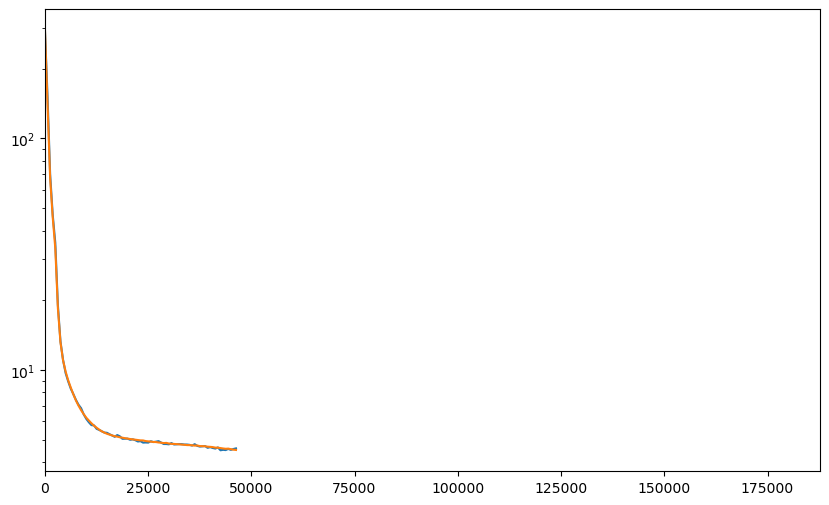

In [ ]:
# small+medium 1401
model = SAARTransformer().cuda()
train(model, train_S, train_A, epochs=10, warmup=2500, warmup_mul=1e-2)

train,val
4.923,4.961


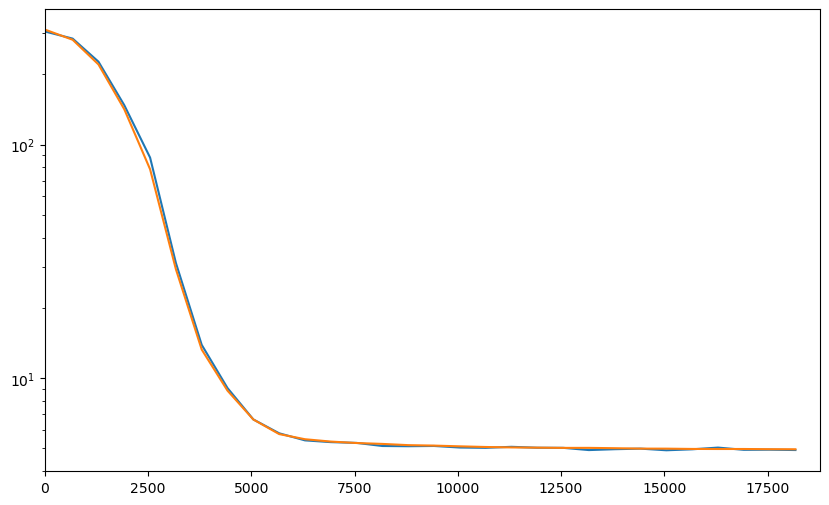

In [ ]:
# small+medium 1401
model = SAARTransformer(depth=2, n_head=2).cuda()
train(model, train_S, train_A, epochs=1, warmup=2500, warmup_mul=1e-2)

In [ ]:
import whisper
from torch import nn
from vector_quantize_pytorch import ResidualVQ

class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)

def sinusoids(length, channels, max_timescale=10000):
    """Returns sinusoids for positional embedding"""
    assert channels % 2 == 0
    log_timescale_increment = np.log(max_timescale) / (channels // 2 - 1)
    inv_timescales = torch.exp(-log_timescale_increment * torch.arange(channels // 2))
    scaled_time = torch.arange(length)[:, np.newaxis] * inv_timescales[np.newaxis, :]
    return torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)

# encoder model, summed semantic tokens
class SEncoder(nn.Module):
    def __init__(self, length=1500, width=384, S_codes=2048, depth=3, n_head=6):
        super(SEncoder, self).__init__()
    
        # embed semantic tokens
        self.embeddings = nn.ModuleList([nn.Embedding(S_codes, width) for i in range(3)])
        self.register_buffer("positional_embedding", sinusoids(length, width))

        self.layers = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])

        self.ln_post = LayerNorm(width)
        
    def forward(self, Stoks):
        xin = sum([enc(Stoks[:,i]) for i,enc in enumerate(model.encoder.embeddings)]).unsqueeze(0)

        assert xin.shape[1:] == self.positional_embedding.shape, "incorrect semantic token shape"
        xin = (xin + self.positional_embedding).to(xin.dtype)

        return self.ln_post(self.layers(xin))

# AR decoder, accepts and outputs interleaved acoustic tokens (1024 is a start of sequence token)
# this one embedds uses separate matrices for each RQ quantizer
class ADecoder(nn.Module):
    def __init__(self, length=2250, width=384, A_codes=1024, depth=3, n_head=6):
        super(ADecoder, self).__init__()
    
        # embed semantic tokens
        self.embeddings = nn.ModuleList([nn.Embedding(A_codes+1, width) for i in range(2)])
        self.register_buffer("positional_embedding", sinusoids(length*2, width))
        
        self.layers = nn.ModuleList([
            whisper.model.ResidualAttentionBlock(width, n_head, cross_attention=True) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)
        
        mask = torch.empty(length*2, length*2).fill_(-np.inf).triu_(1)
        self.register_buffer("mask", mask, persistent=False)

    def forward(self, Atoks, xenc):
        Aembs = torch.stack([emb(torch.tensor([1024] + list(t)[:-1]).cuda())
                             for t,emb in zip(ys, self.embeddings)], dim=1)
        Aembs = Aembs.reshape(-1, Aemb.shape[-1]).cuda().unsqueeze(0)

        xin = (Aembs + self.positional_embedding[:Aembs.shape[1]]).to(xenc.dtype)
    
        x = xin
        for l in self.layers: x = l(x, xenc, mask=self.mask)
        
        x = self.ln_post(x)
        
        logits = torch.stack([(vs @ emb.weight.to(x.dtype).T)
                              for vs, emb in zip(x.reshape(-1,2,x.shape[-1]).transpose(0,1), self.embeddings)], dim=0).float()
        return logits

class SAARTransformer(nn.Module):
    def __init__(self, width=384, depth=6, n_head=6):
        super(SAARTransformer, self).__init__()

        self.encoder = SEncoder(width=width, n_head=n_head, depth=depth//2)
        self.decoder = ADecoder(width=width, n_head=n_head, depth=depth//2)
                
    def forward(self, Stoks, Atoks):
        xenc = self.encoder(Stoks)
        logits = self.decoder(Atoks, xenc)
        loss = F.cross_entropy(logits.view(-1,logits.shape[-1]), Atoks.view(-1))
        return logits, loss

train,val
128.318,123.102
9.512,9.192
5.255,5.255
5.018,5.057
4.877,4.872
4.801,4.808
4.780,4.771
4.723,4.740
4.712,4.725
4.702,4.713


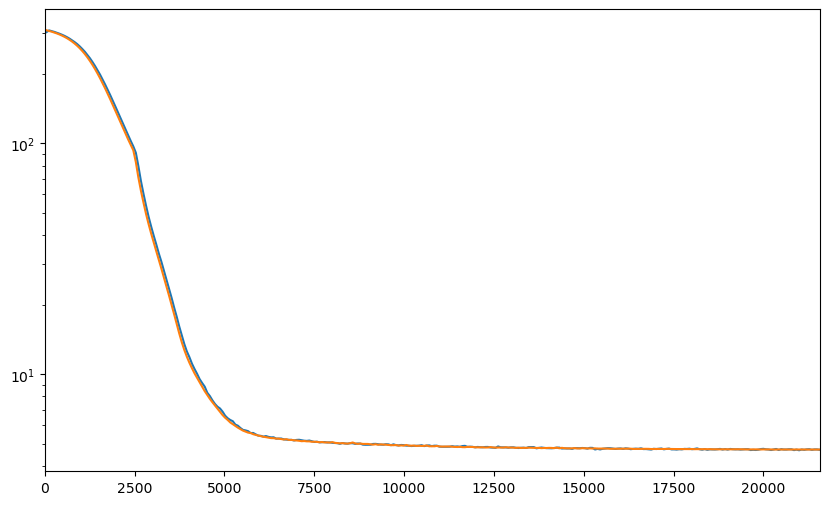

In [ ]:
model = SAARTransformer(depth=3).cuda()
train(model, train_S, train_A, epochs=10, warmup_mul=1e-2, warmup=2500)

train,val
42.543,41.837
20.853,20.976
10.236,10.348
7.208,7.270
5.514,5.595
5.112,5.169
4.917,5.021
4.819,4.874
4.719,4.791
4.646,4.726


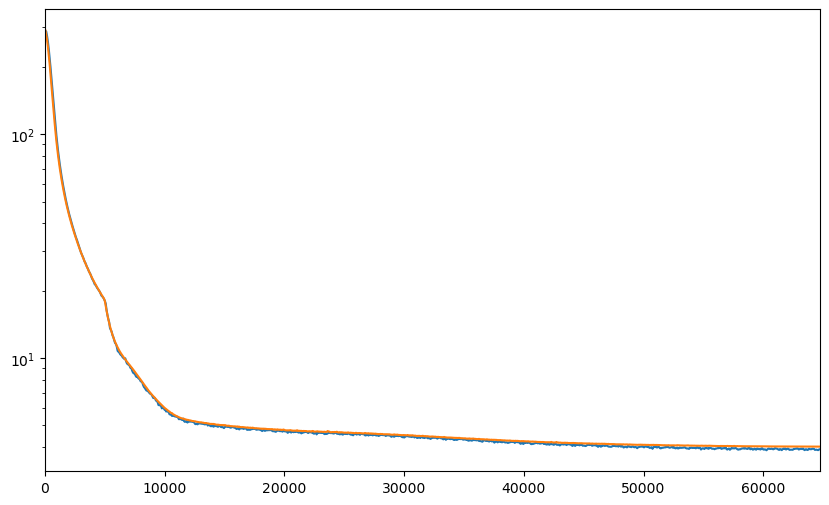

In [ ]:
model = SAARTransformer().cuda()
train(model, train_S, train_A, epochs=30, warmup_mul=1e-2)

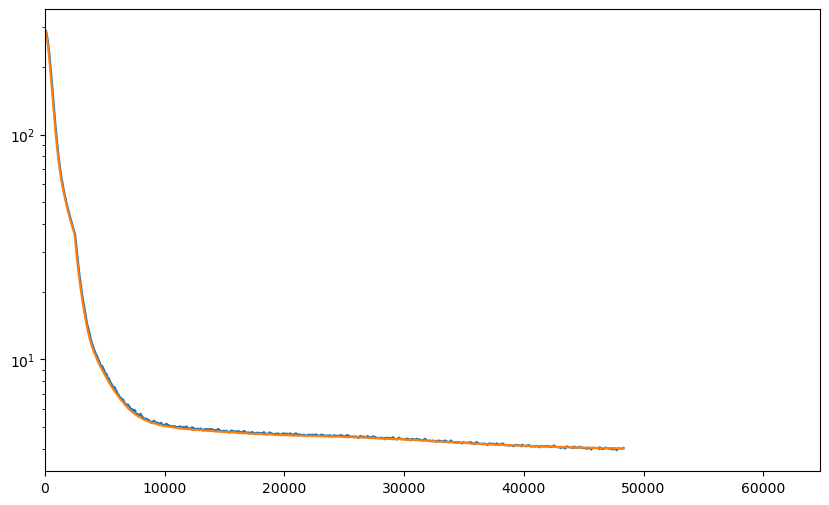

train,val
43.099,42.032
10.466,10.135
6.642,6.515
5.384,5.318
5.036,4.960
4.888,4.837
4.771,4.741
4.684,4.667
4.637,4.619
4.599,4.572


In [ ]:
model = SAARTransformer().cuda()
train(model, train_S, train_A, epochs=30, warmup=2500, warmup_mul=1e-2)

In [ ]:
torch.save(model.state_dict(), 'saar-18h.pt')

In [ ]:
model.load_state_dict(torch.load('saar-18h.pt'))

<All keys matched successfully>

## Naively generate some data

The performance is terrible because we run the whole sequence though the model
for each token (without caching). The outputs should be correct though.

In [ ]:
train_A[0][0,:,11250:11250+2250].T.reshape(-1)

tensor([475, 516, 796,  ..., 512, 320, 185], device='cuda:0')

In [ ]:
# the model is just looping over a few tokens (like a badly trained decoder-only AR)
Stoks = train_S[0][5].cuda().to(torch.long)
toks = [1024,475,516]
for i in range(500):
    p, loss = model(Stoks, torch.tensor(toks).cuda())
    print(p.argmax(-1))
    toks.append(p.argmax(-1)[0,-1].item())

tensor([[106, 106, 913]], device='cuda:0')
tensor([[106, 106, 913, 475]], device='cuda:0')
tensor([[106, 106, 913, 475, 475]], device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913]], device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913]], device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475]], device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475]], device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913]], device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913]],
       device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475]],
       device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475]],
       device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424]],
       device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424]], device='cuda:0')
tensor([[106, 

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475]], device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424]], device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 4

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913]], device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424]], device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913,

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424]],
       device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 42

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475]], device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
    

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424]], device='cuda:0')
tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913,

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424]], device='cuda:0')
tensor([[

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

tensor([[106, 106, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 913, 424, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475,
         475, 913, 913, 475, 475, 913, 913, 475, 475, 913, 913, 475, 475, 913,
         913, 475, 475, 913, 913, 475, 475, 913, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424,
         424, 475, 475, 424, 424, 475, 475, 424, 424, 475, 475, 424, 424, 475,
         475, 424, 424, 475, 475, 424, 424, 475, 475

## Convolutional feed-forward models

In [ ]:
class ResBlock1d(nn.Module):
    def __init__(self, channels, kernel_size, dropout=0):
        super(ResBlock1d, self).__init__()
        self.block = nn.Sequential(*[
            nn.BatchNorm1d(channels),
            nn.Conv1d(channels, channels, kernel_size, padding='same'),
            nn.Dropout1d(p=dropout, inplace=True),
            nn.ELU(),
            nn.BatchNorm1d(channels),
            nn.Conv1d(channels, channels, kernel_size, padding='same'),
        ])
    
    def forward(self, x):
        return F.elu(x + self.block(x))

class ConvModel(nn.Module):
    def __init__(self, S_tokens=2048, A_tokens=1024, width=384, blocks=4):
        super(ConvModel, self).__init__()
        self.A_tokens = A_tokens
        self.encoders = nn.ModuleList([nn.Embedding(S_tokens, width//3) for i in range(3)])
        self.in_layers = nn.Sequential(*[ResBlock1d(width, 5) for i in range(blocks//2)])
        self.expand = nn.Conv1d(width, width*3, 1)
        self.out_layers = nn.Sequential(*[ResBlock1d(width, 5) for i in range(blocks//2)])
        self.decoder = nn.Conv1d(width, A_tokens, 1)
        self.ce_lossf = nn.CrossEntropyLoss()
        
    def forward(self, S_toks, targets=None):
        x = torch.cat([enc(S_toks[:,i]).mT for i,enc in enumerate(self.encoders)]).unsqueeze(0)
#         print(x.shape)
        x = self.in_layers(x)
        x = self.expand(x)
#         print(x.shape)
        x = x.transpose(1,2).reshape(x.shape[0], x.shape[2]*3, x.shape[1]//3).transpose(1,2)
#         print(x.shape)
        x = self.out_layers(x)
        x = self.decoder(x)
#         print(x.shape)
        x = x.mT.reshape(1, S_toks.shape[0]*3//2, 2, self.A_tokens)
        if targets is not None:
            return x, self.ce_lossf(x.reshape(-1,self.A_tokens), targets.reshape(-1))
        else:
            return x

In [ ]:
model = ConvModel().cuda()

In [ ]:
all_samples[5]

(0, 5, 11250)

In [ ]:
# make sure the model works before training
model(train_S[0][5].cuda().to(torch.long), train_A[0][:,11250:11250+2250].cuda())

torch.Size([1, 384, 1500])
torch.Size([1, 1152, 1500])
torch.Size([1, 384, 4500])
torch.Size([1, 1024, 4500])


(tensor([[[[-0.3281, -0.5512,  0.1550,  ...,  0.1393,  0.6800, -0.1819],
           [-0.6994, -0.0314,  0.2831,  ..., -0.4185,  0.2842,  0.3418]],
 
          [[ 0.7656, -0.6679,  0.5287,  ..., -0.0695,  0.1535, -0.0624],
           [-0.1686, -0.0962,  0.4951,  ..., -0.6592,  0.4405, -0.0288]],
 
          [[-0.4884, -0.1901, -0.2341,  ..., -0.4270, -0.2249, -0.2168],
           [ 0.4214,  0.0545, -0.2482,  ...,  0.0404,  0.1331, -0.1932]],
 
          ...,
 
          [[ 0.6581,  0.1526,  0.9235,  ..., -0.4211,  0.0036, -0.3920],
           [ 0.1617, -0.1452, -0.4081,  ...,  0.4594, -0.3952,  0.4006]],
 
          [[-0.1278, -0.2935,  0.2234,  ..., -0.3481,  0.7997, -0.5747],
           [-0.1122, -0.1663,  0.4829,  ..., -0.4480, -0.0087,  0.4564]],
 
          [[-0.1972,  0.4027, -0.1887,  ..., -0.4037, -0.2237, -0.3457],
           [ 0.2991,  0.3062,  0.1931,  ...,  0.0156,  0.3837, -0.0463]]]],
        device='cuda:0', grad_fn=<ReshapeAliasBackward0>),
 tensor(7.0445, device='cuda:0

In [ ]:
train_S = []
train_A = []
for name in progress_bar(list((datadir/'semantic-small/1401/').rglob('*.stoks'))):
    S = torch.load(name)
    train_S.append(S)
    train_A.append(torch.load(datadir/'acoustic-1401'/name.with_suffix('.encodec').name)[0])

all_samples = [(i,Si,Si*2250) for i,S in enumerate(train_S) for Si in range(S.shape[0]-1)]

train,val
5.014,5.057
4.762,4.828
4.610,4.722
4.570,4.619
4.503,4.638
4.435,4.518


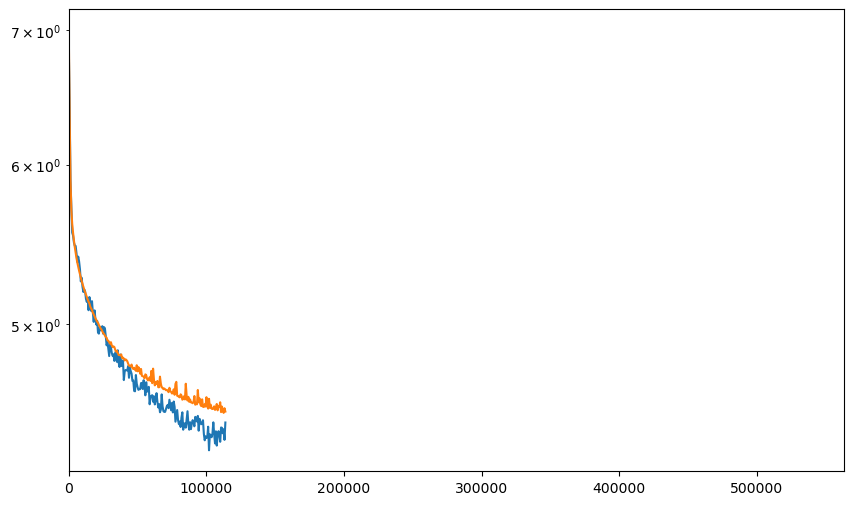

In [ ]:
model = ConvModel().cuda()
train(model, train_S, train_A, warmup=0, epochs=30, lr=1e-4)

train,val
5.480,5.537
5.215,5.243
4.954,5.038
4.775,4.900
4.689,4.799
4.570,4.759
4.489,4.690
4.433,4.654
4.356,4.632
4.339,4.604


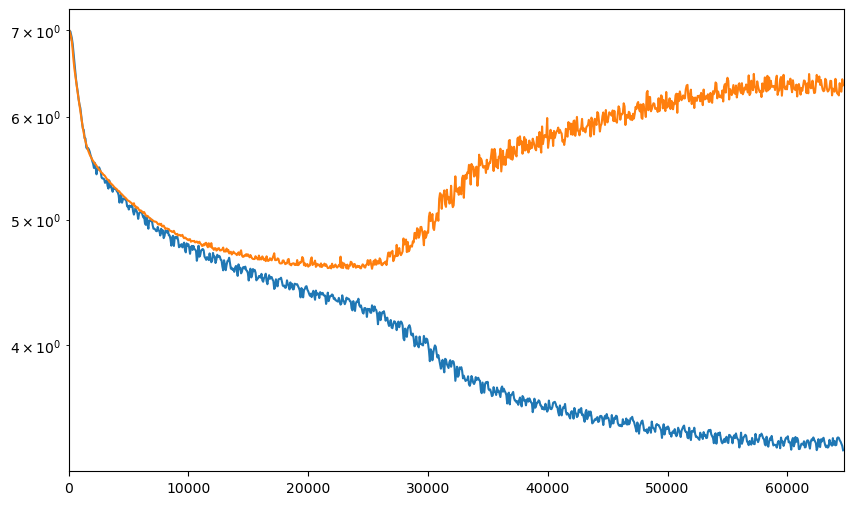

In [ ]:
model = ConvModel().cuda()
train(model, train_S, train_A, warmup=0, epochs=30, lr=1e-4)

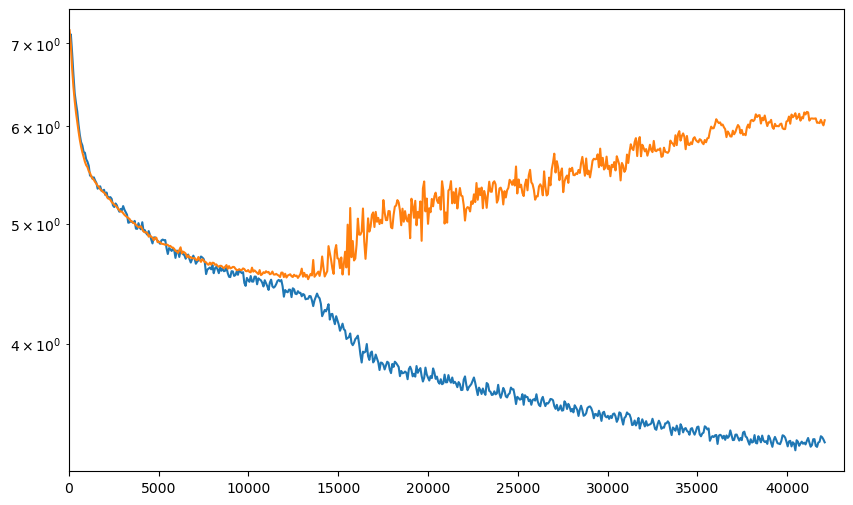

train,val
5.302,5.268
4.916,4.924
4.718,4.742
4.605,4.613
4.482,4.554
4.398,4.556
4.147,4.687
3.865,5.057
3.838,4.988
3.714,5.340


In [ ]:
model = ConvModel(blocks=16).cuda()
train(model, train_S, train_A, warmup=0, epochs=20, lr=1e-4)